In [232]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import numpy.random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)

## 데이터 불러오기

In [233]:
train_data=pd.read_csv("train.csv", index_col=0)
test_data=pd.read_csv("test.csv", index_col=0)

In [234]:
print(train_data.shape)

(15000, 69)


## familysize 이상치 제거

In [235]:
train_data = train_data[train_data['familysize'] < 30]
print('이상치 제거 후:',train_data.shape)

이상치 제거 후: (14678, 69)


## 삭제할 컬럼 list로 저장, drop

In [236]:
drop_list=['hand', 'country', 'introelapse', 'testelapse','surveyelapse','orientation']

In [237]:
train_data.drop(drop_list,axis=1,inplace=True)
test_data.drop(drop_list,axis=1,inplace=True)

## TIPI) 결측값 평균값 대체, 전체 역변환

In [238]:
tp_list=[i for i in train_data.columns if 'TIPI' in i]

In [239]:
#TIPI변수 결측값 평균값 대체
train_data=train_data.fillna(train_data.mean())
test_data=test_data.fillna(test_data.mean())

#전체적으로 역변환
train_data[tp_list]=6-train_data[tp_list]
test_data[tp_list]=6-test_data[tp_list]

## TIPI) 공식대로 계산(5개의 새로운 변수 생성)
- 짝수번호 역변환

In [240]:
train_data['tp_ex']=(train_data['TIPI1']+6-(train_data['TIPI6']))/2
train_data['tp_ag']=(6-(train_data['TIPI2'])+train_data['TIPI7'])/2
train_data['tp_co']=(train_data['TIPI3']+6-(train_data['TIPI8']))/2
train_data['tp_em']=(6-(train_data['TIPI4'])+train_data['TIPI9'])/2
train_data['tp_op']=(train_data['TIPI5']+6-(train_data['TIPI10']))/2

In [241]:
test_data['tp_ex']=(test_data['TIPI1']+6-(test_data['TIPI6']))/2
test_data['tp_ag']=(6-(test_data['TIPI2']+test_data['TIPI7']))/2
test_data['tp_co']=(test_data['TIPI3']+6-(test_data['TIPI8']))/2
test_data['tp_em']=(6-(test_data['TIPI4']+test_data['TIPI9']))/2
test_data['tp_op']=(test_data['TIPI5']+6-(test_data['TIPI10']))/2

In [242]:
#기존 TIPI변수 빼주기(train, test)
train_data.drop(train_data.iloc[:, 26:36], axis=1, inplace=True)
test_data.drop(test_data.iloc[:, 26:36], axis=1, inplace=True)

## 마키아벨리즘 스코어 추가

In [243]:
Answers=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']

<AxesSubplot:>

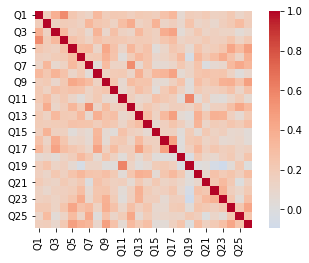

In [244]:
correlations = train_data[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

In [245]:
train_data['Mach_score'] = train_data[Answers].mean(axis = 1)
test_data['Mach_score'] = test_data[Answers].mean(axis = 1)

In [246]:
#기존 Q1~26 변수 삭제
train_data.drop(train_data.iloc[:, :26], axis=1, inplace=True)
test_data.drop(test_data.iloc[:, :26], axis=1, inplace=True)

## 명목형-> str(문자) ->더미변환

In [247]:
train_data['education']=train_data['education'].astype('str')
test_data['education']=test_data['education'].astype('str')

train_data['urban']=train_data['urban'].astype('str')
test_data['urban']=test_data['urban'].astype('str')

train_data['gender']=train_data['gender'].astype('str')
test_data['gender']=test_data['gender'].astype('str')

train_data['engnat']=train_data['engnat'].astype('str')
test_data['engnat']=test_data['engnat'].astype('str')

train_data['religion']=train_data['religion'].astype('str')
test_data['religion']=test_data['religion'].astype('str')

train_data['married']=train_data['married'].astype('str')
test_data['married']=test_data['married'].astype('str')

train_data['ASD']=train_data['ASD'].astype('str')
test_data['ASD']=test_data['ASD'].astype('str')

train_data['voted']=train_data['voted'].astype('str')
test_data['voted']=test_data['voted'].astype('str')

In [248]:
#더미변환
train_data=pd.get_dummies(train_data)
test_data=pd.get_dummies(test_data)
print(train_data.shape, test_data.shape)

(14678, 64) (35452, 63)


## VCL 유효성 검사
- 유효하지 않다고 생각하는 문항 삭제(train_data)

In [249]:
#index3=train_data[train_data['VCL12']==1].index
#train_data.drop(index3, inplace=True)

In [250]:
index=train_data[(train_data['VCL6']==1) | (train_data['VCL9']==1) | (train_data['VCL12']==1)].index
train_data.drop(index, inplace=True)

In [251]:
# VCL1~16 문항 삭제(train, test)
train_data.drop(train_data.iloc[:, :16], axis=1, inplace=True)
test_data.drop(test_data.iloc[:, :16], axis=1, inplace=True)

## 전체적으로 결측값 제거

In [252]:
#결측치 제거(train)
#train_data.dropna(inplace=True)

## train/test 분리
- train_data에서 y컬럼 분리

In [253]:
from sklearn.model_selection import train_test_split
train_y=train_data['nerdiness']
#train_y = 2 - train_y.to_numpy()
train_data.drop('nerdiness',axis=1,inplace=True)
train_x=train_data
test_x=test_data

In [254]:
X_train, X_test, y_train, y_test=train_test_split(train_x, train_y, test_size=0.3, shuffle=True, stratify=train_y, random_state=123)

In [255]:
X_train

,age,familysize,tp_ex,tp_ag,tp_co,tp_em,tp_op,Mach_score,education_1.0,education_2.0,education_2.3151552709495284,education_3.0,education_4.0,urban_0,urban_1,urban_2,urban_3,gender_1.0,gender_1.7024353639402414,gender_2.0,gender_3.0,engnat_1.0,engnat_1.3439956257261978,engnat_2.0,religion_1.0,religion_10.0,religion_11.0,religion_12.0,religion_2.0,religion_3.0,religion_4.0,religion_4.08918078119599,religion_5.0,religion_6.0,religion_7.0,religion_8.0,religion_9.0,voted_1.0,voted_1.6318779085683,voted_2.0,married_1.0,married_1.1812833492953891,married_2.0,married_3.0,ASD_1.0,ASD_1.9391530766068248,ASD_2.0
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3418,19,2.0,2.5,3.0,4.5,3.0,2.5,3.076923,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
756,22,2.0,3.0,1.0,2.5,3.5,1.0,4.615385,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3783,18,2.0,3.0,3.0,3.5,3.5,3.0,4.461538,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
12574,81,1.0,4.0,3.0,1.5,3.0,2.5,3.461538,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
7396,17,1.0,4.5,3.5,3.5,3.5,2.0,4.115385,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,19,3.0,4.5,3.5,3.5,3.0,3.0,3.615385,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2510,22,2.0,3.0,3.0,4.0,4.0,1.0,4.230769,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
7577,14,2.0,4.0,3.5,3.0,4.5,2.5,3.730769,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


## 모델링

In [256]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()

In [257]:
model.fit(X_train, y_train.values.ravel())
pred_train=model.predict_proba(X_train)
print(model.score(X_train, y_train.values.ravel()))

1.0


In [258]:
pred_test=model.predict(X_test)
pred_test=pd.DataFrame(pred_test)
pred_test.columns=['pred_y']
print(pred_test.head(5))

   pred_y
0       1
1       1
2       1
3       1
4       1


In [259]:
#제출용
pred_test=model.predict(test_x)
pred_test=pd.DataFrame(pred_test)
pred_test.columns=['pred_y']
print(pred_test.head(5))
result=pred_test['pred_y']

   pred_y
0       1
1       1
2       1
3       1
4       1


In [262]:
submission = pd.DataFrame({'index' :test_data.index, 'nerdiness':result})
submission.to_csv('submission_randomforest2.csv',index=False)

In [263]:
data=pd.read_csv("submission_randomforest2.csv")

## + LGBM 코드

In [39]:
#pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [72]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [73]:
lgbm_clf = LGBMClassifier(
            n_estimators=1000
        )
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(n_estimators=1000)

In [74]:
lgbm_pred=lgbm_clf.predict(test_x)

In [75]:
pred_test=pd.DataFrame(lgbm_pred)
pred_test.columns=['pred_y']
print(pred_test.head(5))
result=pred_test['pred_y']

   pred_y
0       0
1       1
2       1
3       1
4       1


In [76]:
submission = pd.DataFrame({'index' :test_data.index, 'nerdiness':result})
submission.to_csv('submission_lgbm2.csv',index=False)

In [79]:
data=pd.read_csv("submission_lgbm2.csv")

In [81]:
data.head(20)

,index,nerdiness
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,1
